Мы ищем точки роста на следующий год и хотим исследовать две темы: 

1. **Тренировки**: как они распределяются во времени и по тренерам, как обстоят дела в разных клубах.
2. **Клиентов**: как их можно сегментировать, какие у них привычки.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
# загружаем данные

workouts = pd.read_csv('workouts.csv', parse_dates=['start_at'])
users = pd.read_excel('users.xlsx')

# сразу создадим новый датафрейм, в котором соединены уроки и пользователи

workouts_users =  pd.merge(workouts, users, 
                     how='left',
                     left_on='client_id', right_on='user_id')

In [3]:
workouts.head()

,workout_id,cost,start_at,status,workout_schedule_type,client_id,client_status,workout_type,trainer_department,trainer_id
0,30793909,NaN,2020-11-13 12:45:00,success,trial,22034,NaN,general,Sales,10722051
1,31123309,750.0,2020-11-21 13:00:00,success,regular,22034,new,general,Spartacus,940642
2,31412167,750.0,2020-11-28 13:00:00,success,regular,22034,new,general,Spartacus,940642
3,31703605,750.0,2020-12-05 13:00:00,success,regular,22034,active,general,Spartacus,940642
4,26904500,NaN,2020-08-06 18:20:00,success,trial,88101,NaN,general,Sales,3826530


In [4]:
users.head()

,first_contact_datetime,age,free_workout_datetime,first_payment_datetime,workouts_successful,workouts_total,months_active,user_id,region,geo_group
0,2020-08-08 13:57:25,NaN,2020-08-08 19:00:00,2020-08-08 21:18:34,10,13,2,2790000,NaN,СНГ
1,2020-05-02 00:30:02,NaN,2020-05-05 18:20:00,2020-05-05 18:40:29,26,38,7,780106,NaN,СНГ
2,2019-06-27 13:10:33,30.0,NaN,2020-03-18 16:06:43,27,33,6,1133376,NaN,СНГ
3,2020-04-22 15:37:58,22.0,2020-04-27 09:00:00,2020-04-27 09:41:37,59,59,8,1996499,NaN,СНГ
4,2016-06-23 16:21:40,24.0,2020-04-13 19:00:00,2020-04-13 19:16:51,8,12,2,57899,Москва и Московская область,Москва


In [5]:
workouts['start_at'] = workouts['start_at'].apply(datetime.datetime.date)# отрезаем время


In [6]:
workouts['start_at'] = pd.to_datetime(workouts['start_at'])

In [7]:
workouts = workouts.loc[workouts['start_at'] <= datetime.datetime(2020,11,30)]#дропаем не полный декабрь

In [8]:
trainings_by_day = workouts.resample('D',on='start_at')['workout_id'].count()#кол-во тренировок в каждый день

In [9]:
trainings_by_day

start_at
2020-01-01      1
2020-01-02      4
2020-01-03      5
2020-01-04      5
2020-01-05      9
             ... 
2020-11-26    483
2020-11-27    379
2020-11-28    294
2020-11-29    262
2020-11-30    458
Freq: D, Name: workout_id, Length: 335, dtype: int64

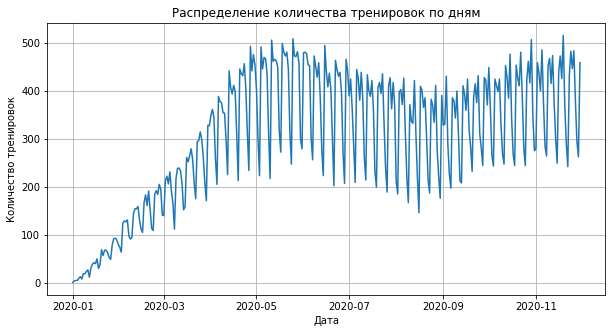

In [10]:
plt.figure(figsize=(10, 5)) # размерность
plt.title('Распределение количества тренировок по дням')
plt.xlabel('Дата')
plt.ylabel('Количество тренировок')
plt.grid()
plt.plot(trainings_by_day) #количество тренировок в каждую неделю 
plt.show()

In [11]:
# выбрали тренеров, которые вели тренировки до 1 ноября
trainers_select = workouts['trainer_id'].loc[workouts['start_at'] < '2020-11-01'] 

# множеством взяли уникальные значения
trainers_select = set(trainers_select)

In [12]:
# взяли тренировки только за ноябрь
november_workouts = workouts.loc[workouts['start_at'].dt.month == 11] 

# берем только активных тренеров
november_workouts = november_workouts.loc[november_workouts['trainer_id'].isin(trainers_select)] 

In [13]:
# кол-во тренировок у каждого тренера
workouts_by_trainer = november_workouts.groupby(['trainer_id','trainer_department'])['workout_id'].count() 

# превращаем series в dataframe, сбрасываем индекс
workouts_by_trainer = workouts_by_trainer.reset_index() 

# переименовываем столбец workout_id, ведь в нем теперь количество тренировок
workouts_by_trainer.columns = ['trainer_id','trainer_department','workouts'] 

workouts_by_trainer.head()

,trainer_id,trainer_department,workouts
0,1994,Spartacus,26
1,4446,Spartacus,9
2,9256,Spartacus,9
3,14431,Spartacus,11
4,15062,Spartacus,8


In [14]:
# посмотрим, какие у нас есть департаменты
departments = set(workouts_by_trainer['trainer_department'])
departments

{'Athletic',
 'Consultant',
 'Cycling',
 'Dinamo',
 'Sales',
 'Spartacus',
 'Sports Reserves'}

In [15]:
trainings_by_day_frame = trainings_by_day.reset_index() # сбросим индекс
trainings_by_day_frame.columns=['workouts_date', 'workouts'] # переименуем столбцы, чтобы названия соответствовали содержимому
trainings_by_day_frame['week_day_num'] = trainings_by_day_frame['workouts_date'].dt.weekday # добавим номер дня недели
trainings_by_day_frame['week_day_name'] = trainings_by_day_frame['workouts_date'].dt.day_name() # добавим название дня недели

trainings_by_day_frame['week_day_num'] += 1

trainings_by_day_frame

,workouts_date,workouts,week_day_num,week_day_name
0,2020-01-01,1,3,Wednesday
1,2020-01-02,4,4,Thursday
2,2020-01-03,5,5,Friday
3,2020-01-04,5,6,Saturday
4,2020-01-05,9,7,Sunday
...,...,...,...,...
330,2020-11-26,483,4,Thursday
331,2020-11-27,379,5,Friday
332,2020-11-28,294,6,Saturday
333,2020-11-29,262,7,Sunday


In [16]:
x = trainings_by_day_frame.groupby(['week_day_num'])['workouts'].mean() 
# напиши здесь код

day_name = {1:'Понедельник',2:'Вторник',3:'Среда',4:'Четверг',5:'Пятница',6:'Суббота',7:'Воскресение'}

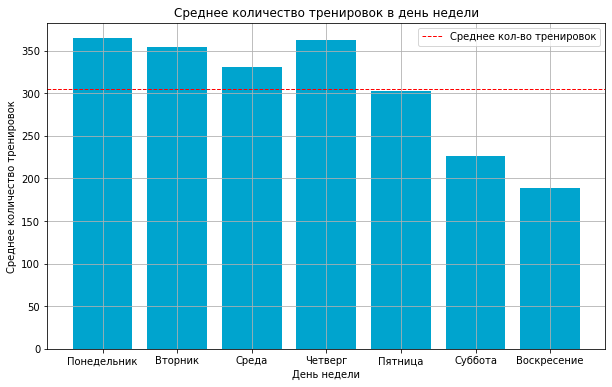

In [17]:
plt.figure(figsize=(10,6))
plt.title("Среднее количество тренировок в день недели")
plt.xlabel('День недели')
plt.ylabel("Среднее количество тренировок")
plt.grid()
plt.bar(x.index.map(day_name), x, color='#00a4ce', )
plt.axhline(x.mean(), 
            color='red', 
            linestyle='--', 
            linewidth=1, 
            label = 'Cреднее кол-во тренировок')
plt.legend()
plt.show()


In [18]:
#выбрали тренеров, которые вели тренировки до 1 ноября
trainers_select = workouts['trainer_id'].loc[workouts['start_at'] < '2020-11-01'] 

#множеством взяли уникальные значения
trainers_select = set(trainers_select) 

In [19]:
# взяли тренировки только за ноябрь
november_workouts = workouts.loc[workouts['start_at'].dt.month == 11] 

# берем только активных тренеров
november_workouts = november_workouts.loc[november_workouts['trainer_id'].isin(trainers_select)] 

In [20]:
#кол-во тренировок у каждого тренера
workouts_by_trainer = november_workouts.groupby(['trainer_id','trainer_department'])['workout_id'].count() 

# превращаем серию в dataframe, сбрасываем индекс
workouts_by_trainer = workouts_by_trainer.reset_index() 

# переименовываем столбец workout_id, ведь в нем теперь количество тренировок
workouts_by_trainer.columns = ['trainer_id','trainer_department','workouts'] 

workouts_by_trainer.head()

,trainer_id,trainer_department,workouts
0,1994,Spartacus,26
1,4446,Spartacus,9
2,9256,Spartacus,9
3,14431,Spartacus,11
4,15062,Spartacus,8


In [21]:
# посмотрим, какие у нас есть департаменты
departments = set(workouts_by_trainer['trainer_department'])
departments

{'Athletic',
 'Consultant',
 'Cycling',
 'Dinamo',
 'Sales',
 'Spartacus',
 'Sports Reserves'}

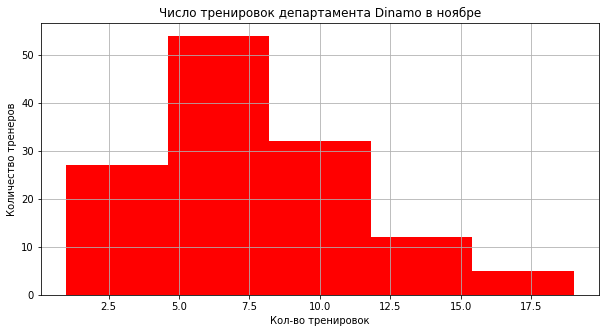

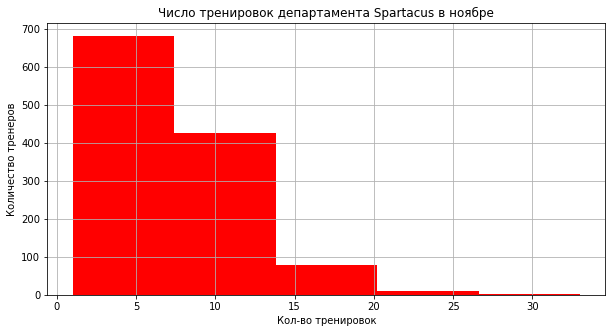

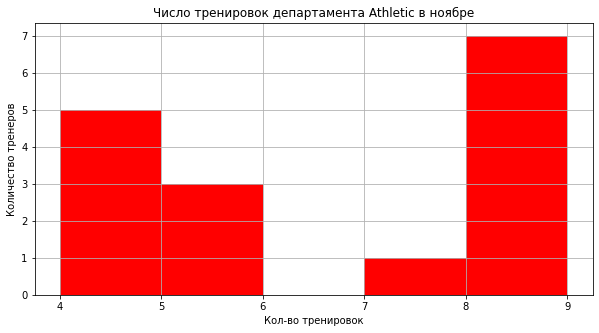

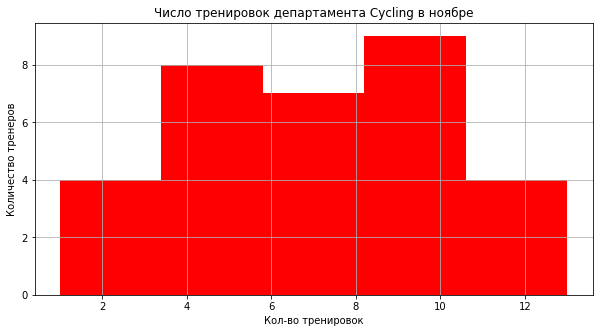

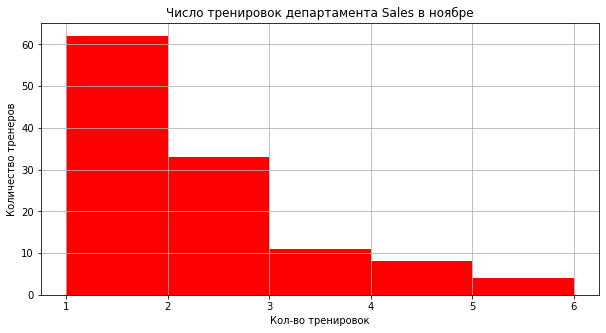

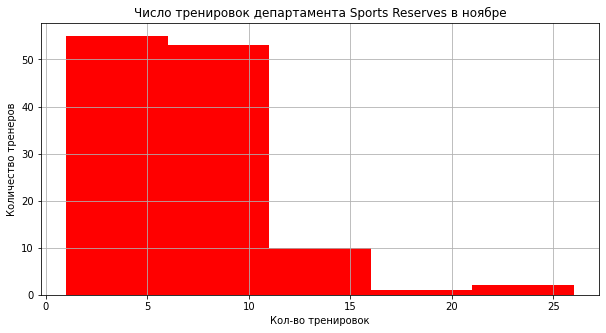

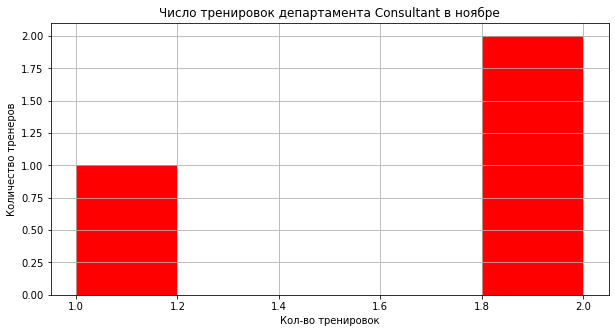

In [22]:
for department in departments:
    to_hist = workouts_by_trainer.loc[workouts_by_trainer.trainer_department==department].workouts
    plt.figure(figsize=(10,5))
    plt.xlabel("Кол-во тренировок")
    plt.ylabel('Количество тренeров')
    plt.hist(to_hist, bins=5, color='red')
    plt.grid()
    plt.title("Число тренировок департамента {} в ноябре".format(department))
   
    plt.show()

In [23]:
# отфильтровали бесплатные тренировки и сделали копию датафрейма
cost_age_data = workouts_users[['status','cost','age']].loc[workouts_users.workout_schedule_type!='trial'].dropna().copy()

# Изменяем тип данных столбцов age и cost на int. Это нужно, чтобы на подписях к диаграммам числа были целыми
cost_age_data['age'] = cost_age_data['age'].apply(int) 
cost_age_data['cost'] = cost_age_data['cost'].apply(int)

# Кодируем столбец status, присваивая 1 в случаях, если он равен failed_by_client и 0 в случае success
cost_age_data['status'] = cost_age_data.status.map({'success':0,'failed_by_client':1})

# создаём агрегированные наборы данных
cost_age_data_agg = cost_age_data.groupby(['cost','age'])['status'].mean().reset_index() #считаем долю прогулов по возрасту и цене 

cost_age_data_agg

,cost,age,status
0,500,5,0.000000
1,500,6,0.500000
2,500,7,0.500000
3,500,8,0.242424
4,500,9,0.235294
...,...,...,...
185,1500,47,0.000000
186,1500,49,0.125000
187,1500,50,0.500000
188,1500,55,0.187500


In [24]:
# напиши здесь код
workouts['trainer_id'] = workouts['trainer_id'].apply(str)

In [25]:
data_for_boxplot = workouts.groupby(['trainer_id'
                                     ,'trainer_department'
                                    ])['workout_id'].count()
data_for_boxplot = data_for_boxplot.reset_index()
data_for_boxplot

,trainer_id,trainer_department,workout_id
0,10007242,Consultant,11
1,10007242,Spartacus,48
2,10011331,Spartacus,5
3,10011599,Spartacus,12
4,10012340,Consultant,9
...,...,...,...
5336,9989342,Sports Reserves,9
5337,9994207,Consultant,10
5338,9994207,Spartacus,36
5339,9994534,Spartacus,6


3. **Построй скаттерплот, который покажет корреляцию прогулов к возрасту**
    - используй группировку и создай датафрейм, где подсчитан процент прогулов аналогично предподготовленному датафрейму `cost_age_data_agg`, но без цен, только с возрастом
    - в функцию, которая строит скаттерплот, можешь добавить любые аргументы, но обязательно используй вот эти:
        - размер графика
        - название графика
        - подпись оси `X`
        
        - подпись оси `Y`
        - задай цвет на графике

4. **Построй скаттерплот, который покажет корреляцию прогулов и к возрасту, и к цене одновременно**
    - создай словарь цветов и цен в переменной `price_color`. Чтобы увидеть все уникальные значения, можно использовать множества
    - в функцию, которая строит скаттерплот, можешь добавить любые аргументы, но обязательно используй вот эти:
        - размер графика
        - название графика
        - подпись оси `X`
        
        - подпись оси `Y`
        - аргумент  `с` - цвета для разных цен
          

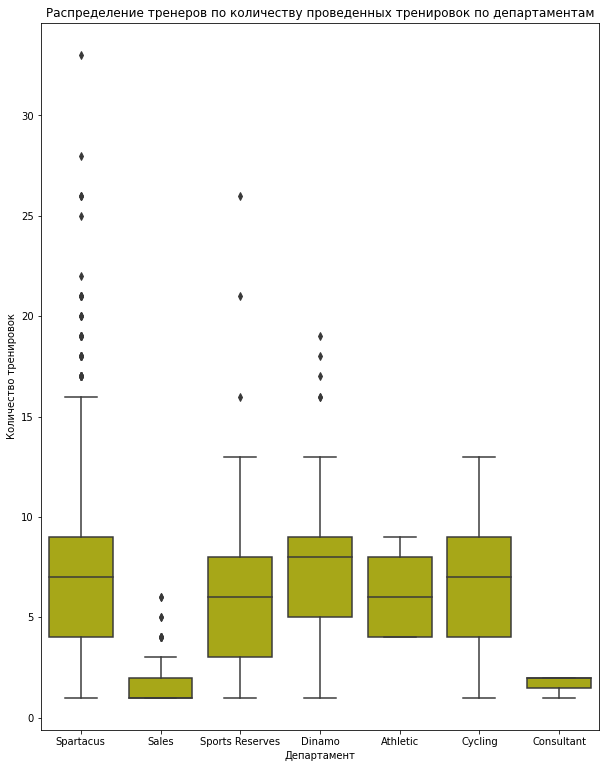

In [27]:
plt.figure(figsize=(10, 13)) 
plt.title('Распределение тренеров по количеству проведенных тренировок по департаментам') 
sns.boxplot(x='trainer_department',
            y='workouts',
            data=workouts_by_trainer, 
            color='y')
plt.ylabel('Количество тренировок') # Подпишем ось Y
plt.xlabel('Департамент') # Подпишем ось Y
plt.show()

In [28]:
# пишем функцию, которая поможет разбить клиентов на возрастные группы

def calculate_age_bins(age):
    if age <= 20:
        return '0-20'
    if age <= 25:
        return '21-25'
    if age <= 30:
        return '26-30'
    if age <= 35:
        return '31-35'
    if age <= 40:
        return '36-40'
    if age <= 45:
        return '41-45'
    if age <= 50:
        return '46-50'
    return '50+'

In [29]:
# кладем в новый столбец возрастную группу
cost_age_data['age_bin'] = cost_age_data.age.apply(calculate_age_bins)

# создаём агрегированный набор данных
cost_age_data_agg = cost_age_data.groupby(['cost','age_bin'])['status'].mean().reset_index()
cost_age_data_agg

,cost,age_bin,status
0,500,0-20,0.286578
1,500,21-25,0.283505
2,500,26-30,0.255597
3,500,31-35,0.165217
4,500,36-40,0.175573
5,500,41-45,0.191489
6,500,46-50,0.285714
7,500,50+,0.307692
8,750,0-20,0.249445
9,750,21-25,0.250124


In [30]:
heat_cost_age_date_agg = cost_age_data_agg.pivot(index="cost", 
                                        columns="age_bin", 
                                        values="status")

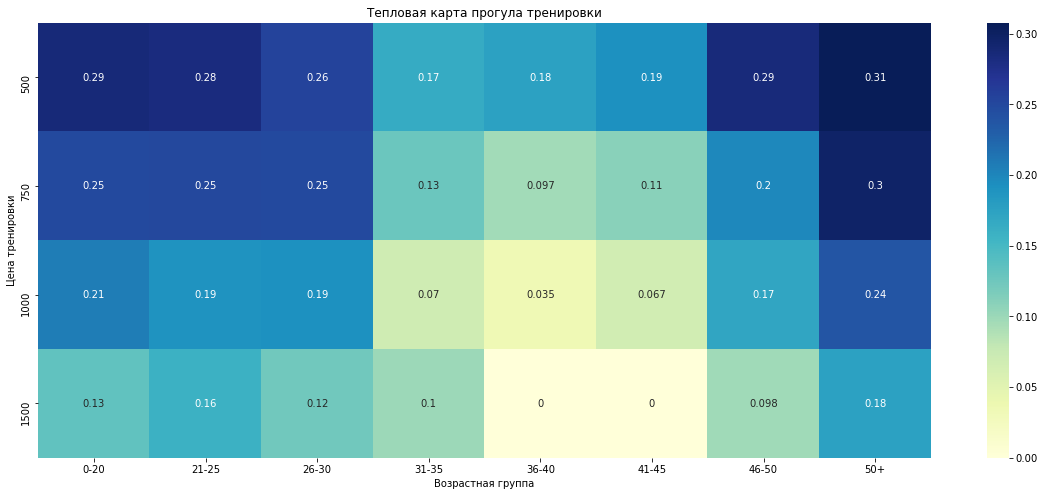

In [31]:
# напиши здесь код
plt.figure(figsize=(20,8))
sns.heatmap(heat_cost_age_date_agg, 
            annot=True, 
            cmap="YlGnBu")
plt.title("Тепловая карта прогула тренировки")
plt.ylabel("Цена тренировки")
plt.xlabel("Возрастная группа")
plt.show()